# Исследование данных по компьютерным играм

**Описание проекта:**  

В нашем распоряжении данные интернет-магазина компьютерных игр. В них содержатся исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные предоставлены до 2016 года (за 2016 год могут быть неполными).  

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


**Цели исследования:**  
- Выявить закономерности, определяющие успешность игры
- Отработать принцип работы с данными для выявления потенциально популярных продуктов и прогнозирования продаж  

**Ход исследования:**  
Исследование будет состоять из пяти этапов:
1. Знакомство с данными
2. Предобработка данных
3. Исследовательский анализ данных
4. Проверка гипотез
5. Подведение итогов исследования

## Знакомство с данными

**1.1 Откроем файл с данными и сохраним его в переменную data:**

In [1]:
# импорт библиотек:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st

# прочитаем csv-файл и сохраним данные в переменную data
data = pd.read_csv('/datasets/games.csv')

**1.2 Выведем первые 5 строк датафрейма data на экран:**

In [2]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**1.3 Выведем основную информацию о датафрейме с помощью метода info**():

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:**   Датафрейм **data** состоит из 16715 строк и 11 столбцов. В нем содержатся следующие данные об играх:      
- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
- *EU_sales* — продажи в Европе (миллионы проданных копий)
- *JP_sales* — продажи в Японии (миллионы проданных копий)
- *Other_sales* — продажи в других странах (миллионы проданных копий)
- *Critic_Score* — оценка критиков (максимум 100)
- *User_Score* — оценка пользователей (максимум 10)
- *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)

На первом этапе обнаружены следующие *проблемы* в исходных данных:
- нарушения в стиле заголовков
- пропущенные значения  
- некорректные типы данных

Устраним пошагово эти проблемы, чтобы упростить дальнейшую работу с данными для исследования:

## Предобработка данных

### Работа с заголовками
#### Приведём названия столбцов к нижнему регистру:

In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Работа с пропусками  

#### Проверим, сколько данных пропущено в каждом из столбцов:

In [5]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,2.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,40.000000


Рассмотрим каждый из столбцов с пропусками детальнее.

#### Столбец *rating*

In [6]:
# проверим уникальные значения столбца:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Для каждой игры на каждой платформе указан свой рейтинг, поэтому заменять пропуски усредненными значениями рейтинга по жанру, по платформе, либо по году релиза будет неправильно. Лучшим решением в этой ситуации будет заменить пропуски на **значение-заглушку:**

In [7]:
# заменим пропуски на значение-заглушку unknown:
data['rating'] = data['rating'].fillna('unknown') 

#### Столбец *critic_score* 

In [8]:
# проверим уникальные значения столбца critic_score:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Показатели **critic_score** являются уникальными оценками критиков для каждой отдельной игры, и любое их усреднение может исказить данные.  
Предлагаю поступить аналогично и использовать значение-заглушку:

In [9]:
# заменим пропуски на значение-заглушку -1:
data['critic_score'] = data['critic_score'].fillna(-1)

#### Столбец *user_score*

In [10]:
# проверим уникальные значения столбца user_score:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Ещё в первом разделе исследования в столбце было обнаружено необычное значение 'tbd'.      
**TBD** - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. В нашем случае это означает, что рейтинг игры ещё не определен.  

Для удобства работы предлагаю заменить данную аббревиатуру на NaN-значение:

In [11]:
data.loc[data['user_score'] == 'tbd','user_score'] = np.nan

Сами пропуски в столбце user_score являются уникальными оценками пользователей для каждой отдельной игры.   
Аналогично предыдущему столбцу, предлагаю заменить пропуски на значение-заглушку:

In [12]:
# заменим пропуски на значение-заглушку -1:
data['user_score'] = data['user_score'].fillna(-1)

#### Столбец  *year_of_release*

In [13]:
# проверим уникальные значения столбца year_of_release:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Столбец никак не связан с другими данными, логичную замену предположить невозможно.  
Возможные причины пропусков:
- при заполнении данных забыли указать год выпуска игры
- год выпуска игры неизвестен
- потеря данных, обусловленная техническим сбоем   

Предлагаю удалить пропуски в данном столбце методом **dropna():**

In [14]:
# удалим пропуски в столбце year_of_release:
data = data.dropna(subset=['year_of_release']) 

**Вывод:**  Больше всего пропущенных значений обнаружено в столбцах *critic_score, user_score, rating.*   
Все параметры в столбцах являются уникальными характерисками, усреднение которых может сильно исказить данные.  
В такой ситуации возможно несколько решений:  
- замена пропусков на значение-заглушку
- игнорирование пропусков и дальнейшая их фильтрация при работе с данными  
- удаление пропущенных значений    

### Работа с типами данных

####  Проверим текущие типы данных:

In [15]:
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

####  Преобразуем типы в некоторых столбцах:

In [16]:
# меняем тип данных:
data = data.astype({'year_of_release':'int', 
                    'critic_score': 'int', 
                    'user_score': 'float64'})
data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         int32
user_score         float64
rating              object
dtype: object

**Вывод:** изменение типов данных требовалось по следующим причинам:
- В столбцах *year_of_release* и *critic_score* представлены целочисленные значения, изначальный формат для хранения данных float64 не требуется
- Столбец *user_score* содержит дробные значения, с которыми удобнее работать в формате float64.  
Изначальный формат object был указан ввиду того, что в данных помимо пропусков присутсвует значение **tbd**.

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [17]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38


**Вывод:** Во время предобработки данных были устранены:  
- нарушения в стиле заголовков
- пропущенные значения
- некорректные типы данных

Также добавлен столбец с суммарными продажами по всем регионам.
Теперь данные готовы к дальнейшему исследованию.

## Исследовательский анализ данных

###  Проверим, сколько игр выпускалось в разные годы:

In [18]:
# объединим игры по году выпуска и исключим строки, где указаны значения-заглушки:
grouped_games = data.query('year_of_release != -1').pivot_table(
    index='year_of_release', 
    values='name', 
    aggfunc='count').reset_index()
grouped_games.head()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


In [19]:
# посмотрим на характерные значения сводной таблицы:
grouped_games['name'].describe()

count      37.000000
mean      444.432432
std       451.604334
min         9.000000
25%        36.000000
50%       338.000000
75%       762.000000
max      1427.000000
Name: name, dtype: float64

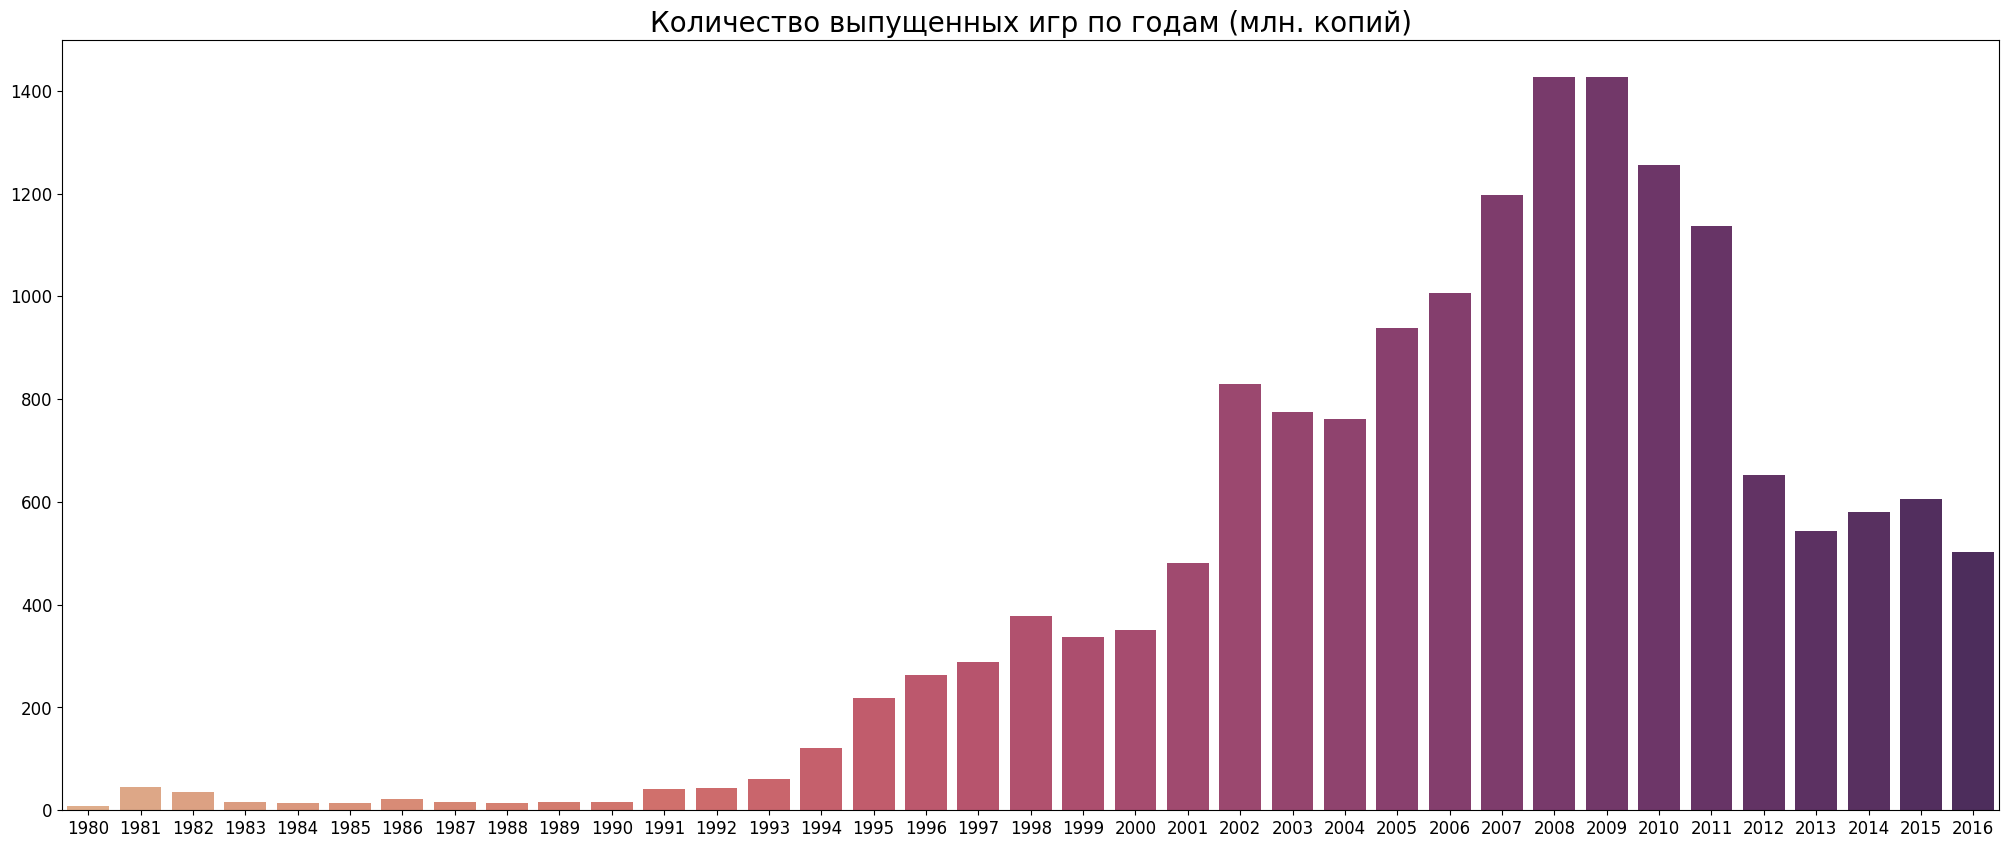

In [20]:
# визуализируем полученные данные:
plt.subplots(figsize=(25,10))
plt.tick_params(axis='both', which='major', labelsize=12)
ax= sns.barplot(data=grouped_games, x="year_of_release", y="name", palette= 'flare')
ax.set_title('Количество выпущенных игр по годам (млн. копий)', fontsize=20)
ax.set(xlabel='', ylabel='')
plt.show()

**Выводы:**
- В датасете представлены данные с 1980 по 2016 годы
- Пик по количеству выпущенных игр приходится на 2008-2009 годы  
- К средним показателям по количеству выпущеных игр индустрия вышла после 2000 годов  
- После 2011 года наблюдается резкий спад по количеству выпущенных игр  

Индустрия компьютерных игр быстро меняется и требует постоянного совершенствования используемых технологий. Модели игровых консолей регулярно обновляются, и для них выпускаются уже новые игры. Как следствие, на старые игры падает покупательский спрос. 

Основная цель текущего исследования - отработать принцип работы с данными для выявления потенциально популярных продуктов и прогнозирования продаж. В связи с этим, необходимости работать с данными за все года нет. Разумнее будет выделить актуальный период данных. Вернемся к этому в следующем разделе. 

### Изучим, как менялись продажи по платформам:  

#### Выявим 10 платформ-лидеров с наибольшими суммарными продажами:

In [21]:
# посчитаем суммарные продажи по каждой из платформ:
best_sales = data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()

# выведем 10 лидеров по количеству суммарных продаж:
top_10 = best_sales.head(10)
top_10

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


In [22]:
# сохраним названия 10 лидеров в список для дальнейшей фильтрации:
top_10_filter = top_10['platform'].tolist()

# отфильтруем лидеров по продажам:
top_10_filter = data.query('platform == @top_10_filter')

#### Построим распределение суммарных продаж по годам среди платформ-лидеров:

In [23]:
# построим сводную таблицу по лидерам:
sales_by_years = top_10_filter.pivot_table(
    index=(['platform', 'year_of_release']), values='total_sales', aggfunc='sum').reset_index()
sales_by_years

,platform,year_of_release,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78
...,...,...,...
92,X360,2012,99.74
93,X360,2013,88.58
94,X360,2014,34.74
95,X360,2015,11.96


#### Покажем наглядно, как менялись продажи по платформам в течение времени:

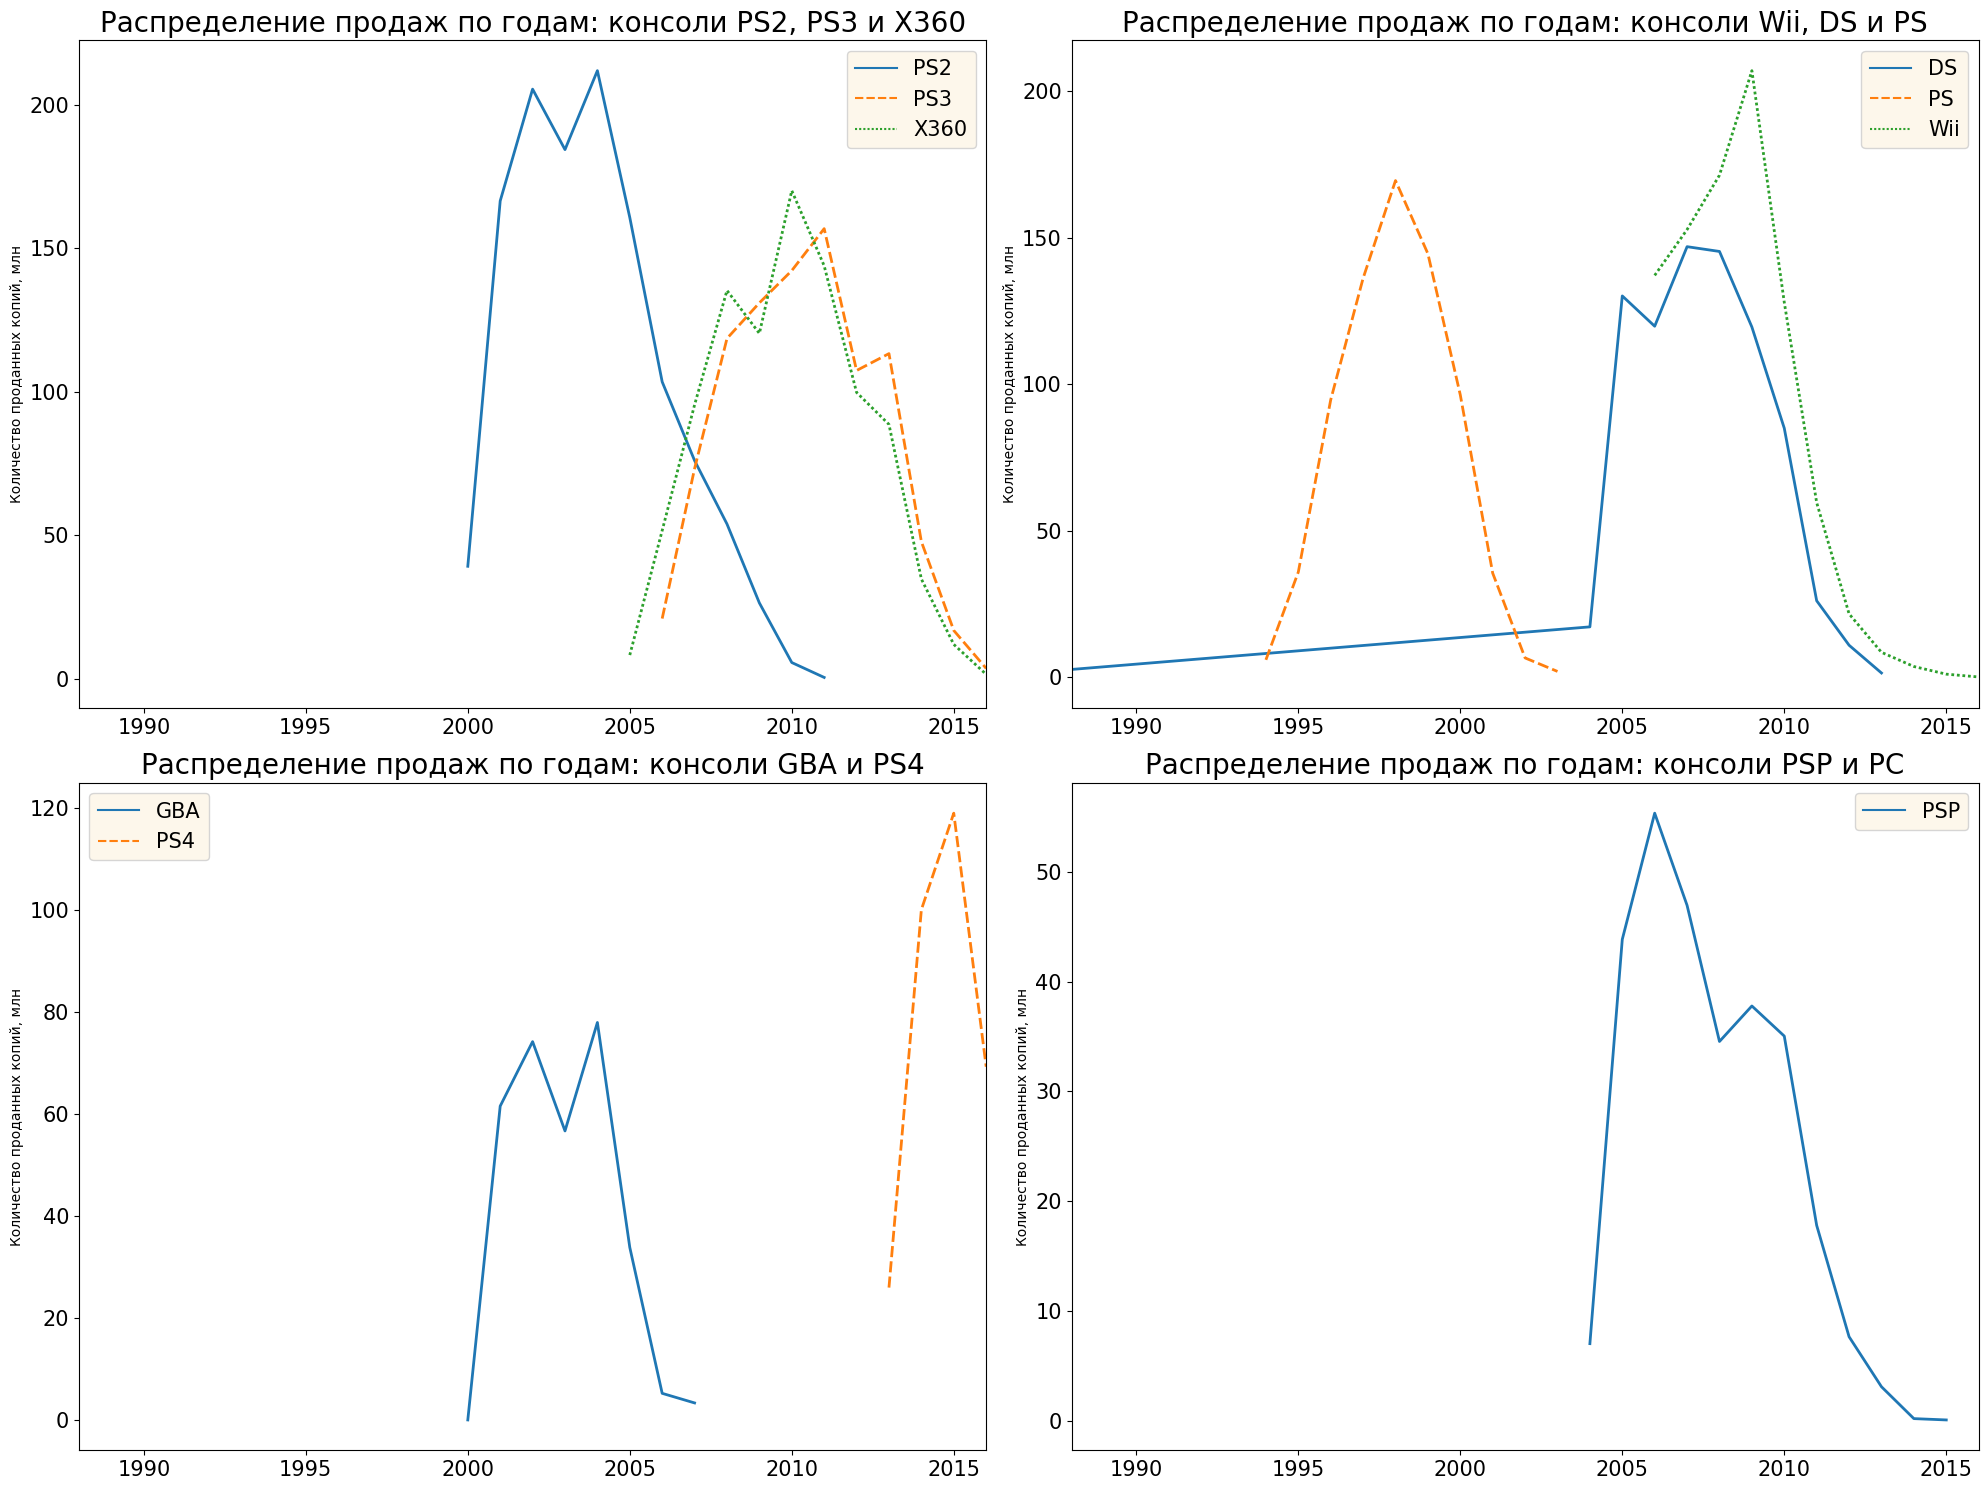

In [24]:
# зададим параметры для будущих графиков:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# сохраним данные для платформ PS2, PS3 и X360:
temp = sales_by_years[sales_by_years['platform'].isin(['PS2', 'X360', 'PS3'])]

# построим график для платформ PS2, PS3 и X360:
sns.lineplot(data=temp, 
             x='year_of_release', 
             y='total_sales', 
             hue="platform", 
             style='platform', 
             linewidth= 2,
             ax=axes[0][0]).set(
             xlim=([1988, 2016]),
             xlabel=(''),
             ylabel=('Количество проданных копий, млн'))

# зададим название и параметры графика для удобного отображения:
axes[0][0].tick_params(axis='both', which='major', labelsize=15)
axes[0][0].legend(fontsize = 15, facecolor = 'oldlace')
axes[0][0].set_title('Распределение продаж по годам: консоли PS2, PS3 и X360', fontsize=20)

# сохраним данные для платформ Wii, DS и PS:
temp2 = sales_by_years[sales_by_years['platform'].isin(['Wii', 'DS', 'PS'])]

# построим график для платформ Wii, DS и PS:
sns.lineplot(data=temp2, 
             x='year_of_release', 
             y='total_sales', 
             hue="platform", 
             style='platform', 
             linewidth= 2,
             ax=axes[0][1]).set(
             xlim=([1988, 2016]),
             xlabel=(''),
             ylabel=('Количество проданных копий, млн'))

# зададим название и параметры графика для удобного отображения:
axes[0][1].tick_params(axis='both', which='major', labelsize=15)
axes[0][1].legend(fontsize = 15, facecolor = 'oldlace')
axes[0][1].set_title('Распределение продаж по годам: консоли Wii, DS и PS', fontsize=20)

# сохраним данные для платформ GBA и PS4:
temp3 = sales_by_years[sales_by_years['platform'].isin(['GBA', 'PS4'])]

# построим график для платформ GBA и PS4:
sns.lineplot(data=temp3, 
             x='year_of_release', 
             y='total_sales',
             hue="platform", 
             style='platform', 
             linewidth= 2,
             ax=axes[1][0]).set(
             xlim=([1988, 2016]),
             xlabel=(''),
             ylabel=('Количество проданных копий, млн'))

# зададим название и параметры графика для удобного отображения:
axes[1][0].tick_params(axis='both', which='major', labelsize=15)
axes[1][0].legend(fontsize = 15, facecolor = 'oldlace')
axes[1][0].set_title('Распределение продаж по годам: консоли GBA и PS4', fontsize=20)

# сохраним данные для платформ PSP и PC:
temp4 = sales_by_years[sales_by_years['platform'].isin(['PSP', 'PC'])]

# построим график для платформ PSP и PC:
sns.lineplot(data=temp4,
             x='year_of_release', 
             y='total_sales',
             hue="platform", 
             style='platform', 
             linewidth= 2,
             ax=axes[1][1]).set(
             xlim=([1988, 2016]),
             xlabel=(''),
             ylabel=('Количество проданных копий, млн'))

# зададим название и параметры графика для удобного отображения:
axes[1][1].tick_params(axis='both', which='major', labelsize=15)
axes[1][1].legend(fontsize = 15, facecolor = 'oldlace')
axes[1][1].set_title('Распределение продаж по годам: консоли PSP и PC', fontsize=20)

plt.tight_layout()

**Вывод:** Исходя из полученных графиков, характерный срок, за который появляются новые и исчезают старые платформы ≈ 7 лет.

### Определим актуальный период для дальнейшего исследования:

При определении актуального периода нужно учесть несколько факторов:    
- жизненный цикл игровых консолей (период от выпуска текущей модели до выпуска следующей) 
- актуальность данных на текущий момент  

#### Выясним, за какой характерный срок появляются новые и исчезают старые платформы:

In [25]:
# создадим список, куда запишем "срок жизни" каждой из платформ:
avg_platform_age = []

# вычислим жизненный цикл игровых консолей:
for platform in data['platform'].unique():
    avg_platform_age.append(data.loc[(data['platform'] == platform), 'year_of_release'].max() -
    data.loc[(data['platform'] == platform), 'year_of_release'].min())

# вычислим среднее значение:
from statistics import mean

print('Средний срок жизни платформ составляет:', mean(avg_platform_age), 'лет')

Средний срок жизни платформ составляет: 7 лет


**Вывод:** Новые модели игровых приставок выпускают в среднем раз в 7 лет. На этот показатель стоит ориентироваться, потому что под каждую новую версию консоли выпускается новая версия игры. Как следствие, спрос на игры, выпущенные для старых моделей, падет.    

Однако, не стоит не забывать про главную цель исследования. Чтобы выявить потенциально популярные продукты и суметь спрогнозировать продажи на будущий год, необходимо работать только со свежими данными.

**Предлагаю установить следующий актуальный период: 2014 - 2016 годы и далее работать именно с ним.**

In [26]:
# сохраним данные за актуальный период в новую переменную:
actual_data = data[data['year_of_release'] > 2013]
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,-1.0,unknown,7.98


### Выясним, какие платформы лидируют по продажам:

In [27]:
# приведем столбец year_of_release к сточному формату (это потребуется для корректной визуализации):
import warnings
warnings.simplefilter('ignore')

actual_data['year_of_release'] = actual_data['year_of_release'].astype(str)

In [28]:
# сгруппируем данные по платформам и годам:
actual_data_pivot = actual_data.pivot_table(index=(['platform', 'year_of_release']), values='total_sales', aggfunc='sum')
actual_data_pivot

total_sales
platform year_of_release             
3DS      2014                   43.76
         2015                   27.78
         2016                   15.14
PC       2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2014                    0.24
         2015                    0.12
PSV      2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2014                   54.07
         2015                   60.14
         2016                   26.15

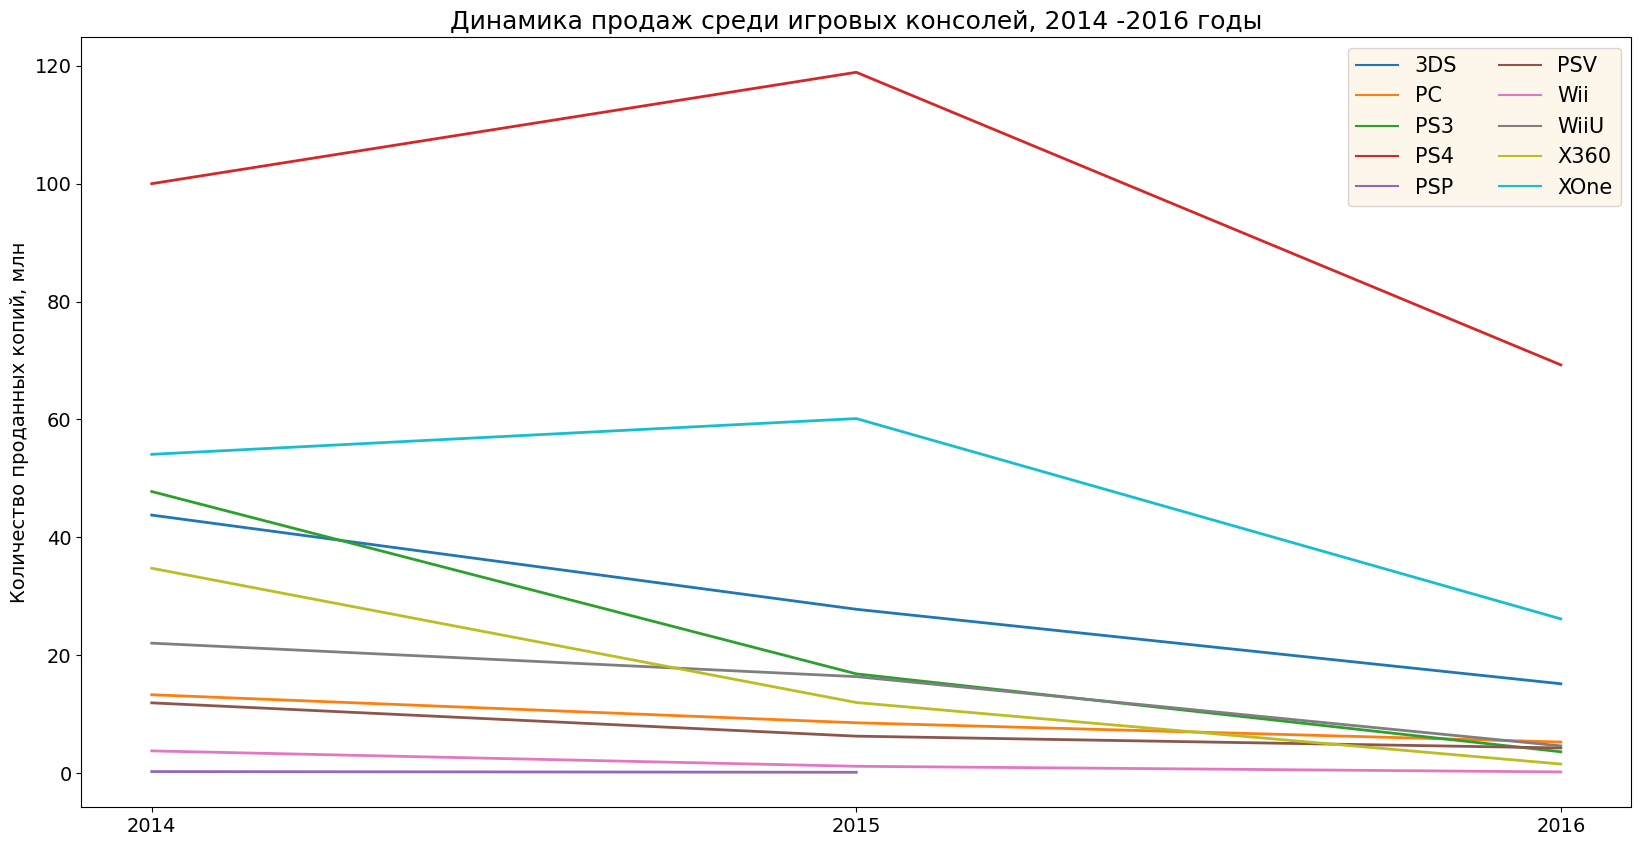

In [29]:
# построим график:
fig, ax = plt.subplots(figsize = (20, 10))
plt.tick_params(axis='both', which='major', labelsize=14)
ax = sns.lineplot(data=actual_data_pivot, x="year_of_release", y="total_sales", hue="platform", linewidth= 2)
ax.set_title('Динамика продаж среди игровых консолей, 2014 -2016 годы', fontsize=18)
ax.set_ylabel('Количество проданных копий, млн', fontsize=14)
ax.set_xlabel('')
ax.legend(fontsize = 15,
          ncol = 2,    
          facecolor = 'oldlace'
         )
plt.show()

**Вывод:** Исходя из графика, потенциальными лидерами по суммарным продажам являются: **PS4, XOne, 3DS.**      
С большим отрывом от остальных платформ лидирует консоль **PS4.** У многих платформ наблюдается падение продаж после 2015 года. Это может быть вызвано тем, что в датасете представлены неполные данные за 2016 год.  

### Построим диаграмму размаха по глобальным продажам игр в разбивке по платформам:

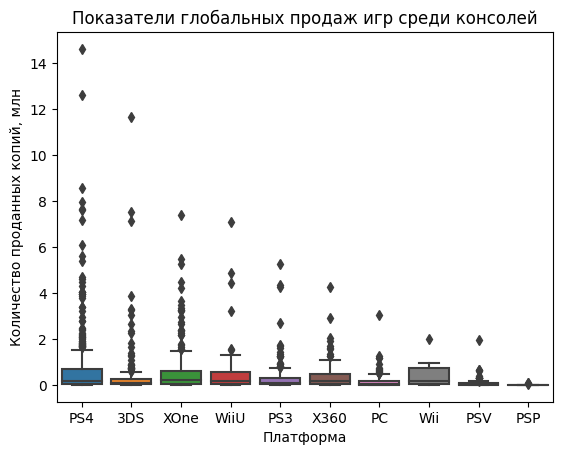

In [30]:
sns.boxplot(data=actual_data, x='platform', y='total_sales')
plt.title('Показатели глобальных продаж игр среди консолей')
plt.xlabel('Платформа', fontsize=10)
plt.ylabel('Количество проданных копий, млн', fontsize=10)
plt.show()

Максимальные значения по продажам наблюдаются у консолей **PS4, 3DS** (около 14 млн. и около 12 млн. проданных копий соответственно).  
Увеличим масштаб графика, чтобы посмотреть на квартили и средние значения: 

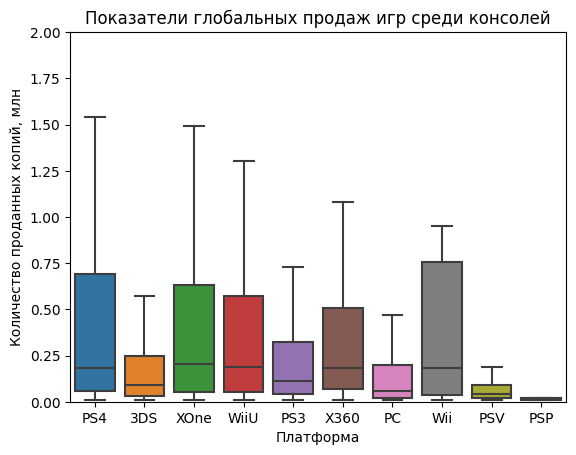

In [31]:
# увеличим масштаб графика, обрезав "усы":
plt.ylim([0,2])
sns.boxplot(data=actual_data, x='platform', y='total_sales', showfliers=False)
plt.title('Показатели глобальных продаж игр среди консолей')
plt.xlabel('Платформа', fontsize=10)
plt.ylabel('Количество проданных копий, млн', fontsize=10)
plt.show()

In [32]:
# проверим характерные значения суммы продаж в разбивке по платформам:
actual_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


**Вывод:** При оценке показателей будем ориентироваться на медианные значения продаж, так как они более устойчивы к аномальным значениям в группе. Диаграмма размаха по глобальным продажам игр показала, что за актуальный период (2014-2016 годы) было продано:
- консоль **PS4** - в среднем 766 тысяч копий
- консоль **XOne** - в среднем 615 тысяч копий
- консоль **X360** - в среднем 615 тысяч копий
- консоль **Wii** - в среднем 589 тысяч копий
- консоль **WiiU** - в среднем 460 тысяч копий
- консоль **PC** - в среднем 434 тысяч копий
- консоль **3DS** - в среднем 408 тысяч копий
- консоль **PS3** - в среднем 311 тысяч копий
- консоль **PSV** - в среднем 76 тысяч копий
- консоль **PSP** - в среднем 28 тысяч копий  

Таким образом, изначальный список лидеров изменился: теперь лидируют консоли **PS4, XOne и X360.**

### Проверим наличие связей между продажами и отзывами пользователей и критиков на примере самой популярной платформы - PS4:  

#### Построим диаграмму рассеяния:

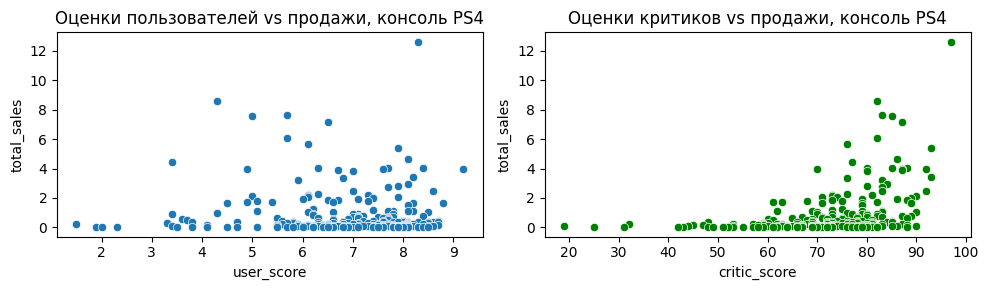

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

temp = actual_data.loc[(actual_data['platform'] == 'PS4') &
                       (actual_data['user_score'] != -1) & 
                       (actual_data['critic_score'] != -1)] 

sns.scatterplot(data=temp, x='user_score', y='total_sales', ax=axes[0]).set(
        title= f'Оценки пользователей vs продажи, консоль PS4')

sns.scatterplot(data=temp, x='critic_score', y='total_sales', ax=axes[1], color='green').set(
        title= f'Оценки критиков vs продажи, консоль PS4')
plt.tight_layout()

#### Поссчитаем коэффициент корреляции между параметрами:

In [34]:
# создадим фильтр для конкретной платформы и исключения значений-заглушек:
filter = (actual_data['platform'] == 'PS4') & (actual_data['user_score'] != -1) & (actual_data['critic_score'] != -1)

# посчитаем корреляцию по Пирсону:
dep_user_score = actual_data.loc[filter, 'user_score'].corr(actual_data['total_sales'])
dep_critic_score = actual_data.loc[filter, 'critic_score'].corr(actual_data['total_sales'])

print(f'Зависимость суммы продаж от оценок пользователей: {dep_user_score:.1%}')
print(f'Зависимость суммы продаж от оценок критиков: {dep_critic_score:.1%}')

Зависимость суммы продаж от оценок пользователей: -4.3%
Зависимость суммы продаж от оценок критиков: 40.2%


**Вывод:** Исходя из графиков и корреляции на примере самой популярной платформе **PS4**, можно сделать следующие выводы:  
- Отзывы пользователей ***не влияют*** на суммарные продажи консоли. Отрицательная корреляция говорит о том, что с ростом одной величины связано уменьшение другой, но процент настолько маленький, что связь не прослеживается.   
- Отзывы критиков ***влияют*** на суммарные продажи консоли. Это видно как на графике, так и в значении коэффициента. 


###  Соотнесём полученные выводы с продажами игр на других платформах:

#### Построим диаграммы рассеяния для всех консолей:

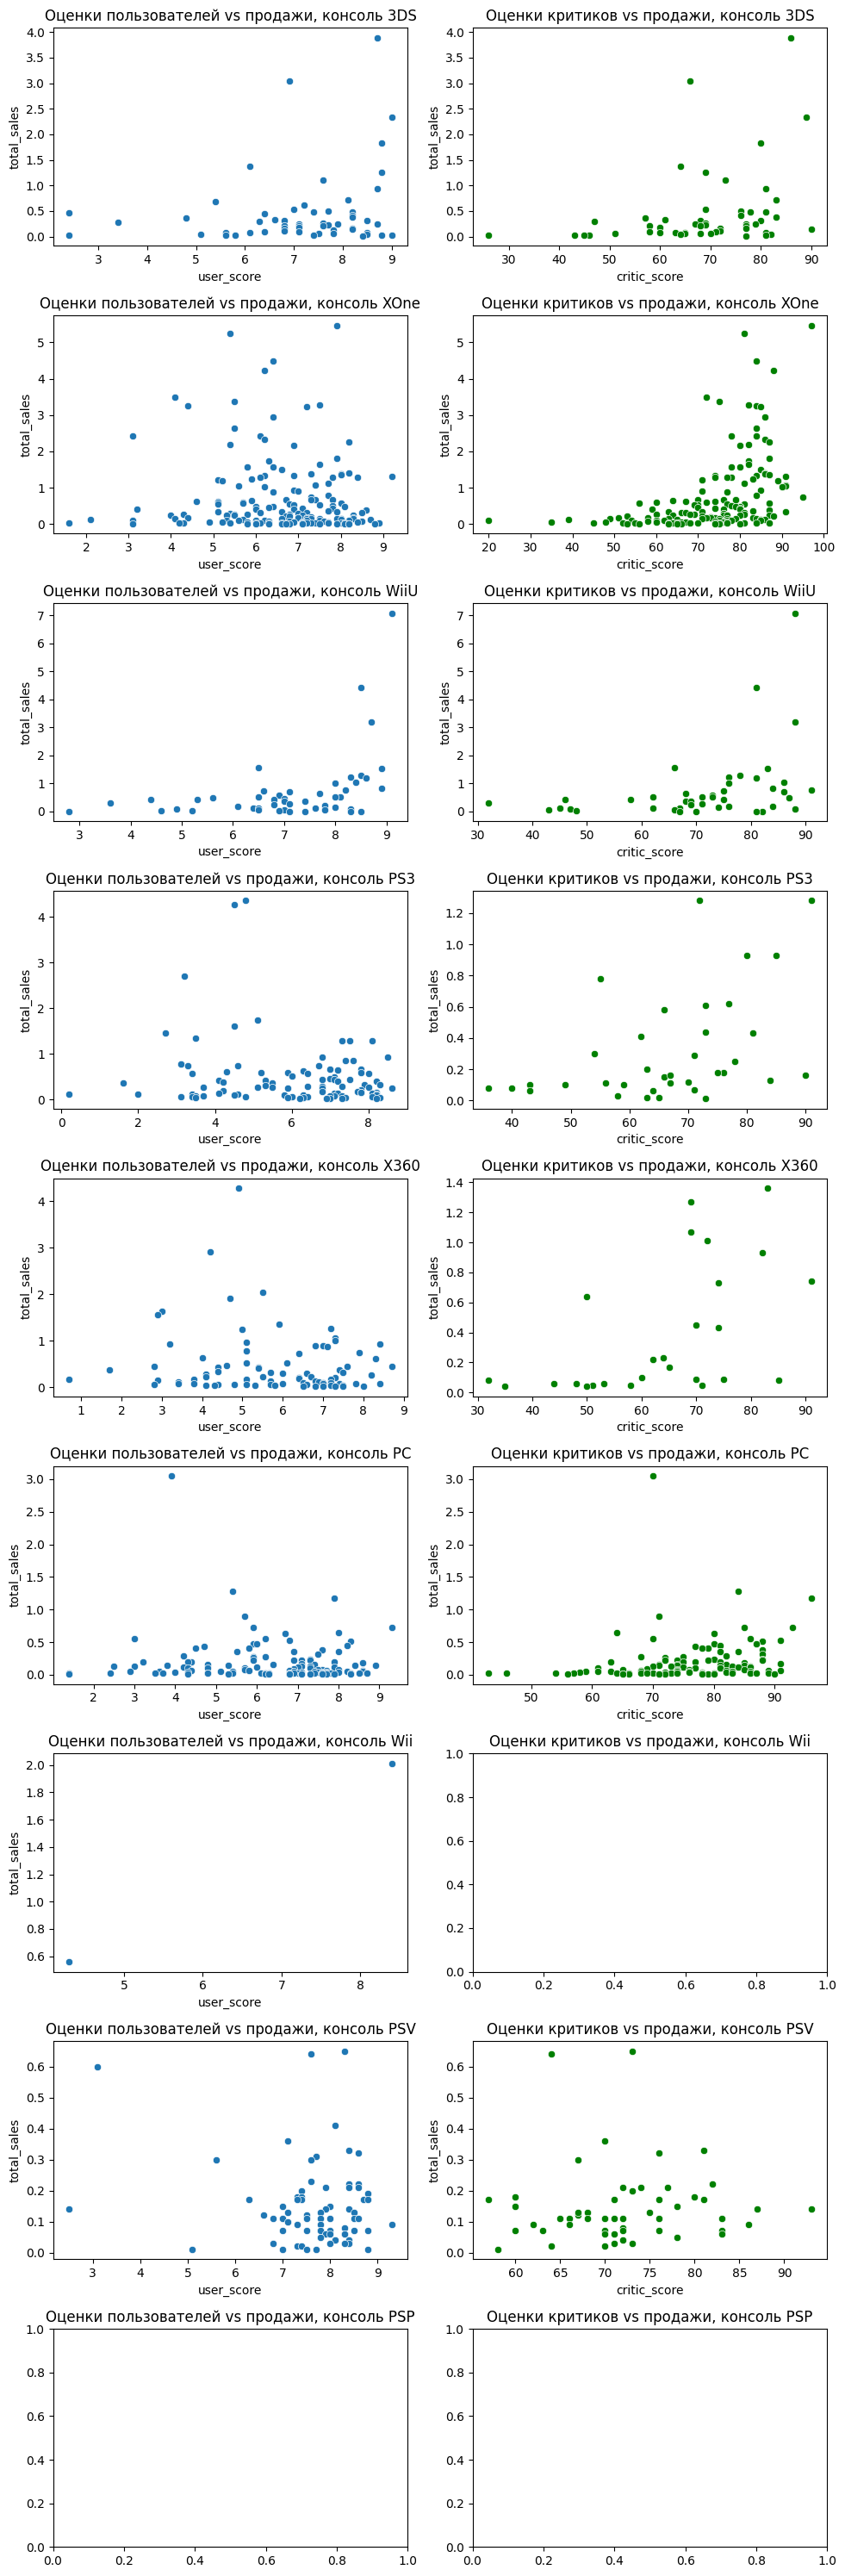

In [35]:
# зададим параметры графика:
fig, axes = plt.subplots(9, 2, figsize=(10,30))
count = 0

 
# напишем цикл, который пройдется по каждой консоли и построит 2 графика:
for console in actual_data['platform'].unique():
    if console == 'PS4':
        continue
    temp = actual_data[actual_data['platform'] == console]
    sns.scatterplot(data=temp[temp['user_score'] != -1], 
                    x='user_score', 
                    y='total_sales', 
                    ax=axes[count][0]).set(
        title= f'Оценки пользователей vs продажи, консоль {console}')
    
    sns.scatterplot(data=temp[temp['critic_score'] != -1], 
                    x='critic_score', 
                    y='total_sales', 
                    color='green', 
                    ax=axes[count][1]).set(
        title= f'Оценки критиков vs продажи, консоль {console}')
    count += 1
plt.tight_layout()

#### Посчитаем коэффициент корреляции между параметрами:

In [36]:
# посчитаем корреляцию по Пирсону:
for console in actual_data['platform'].unique():
    if console == 'PS4':
        continue
    temp = actual_data[actual_data['platform'] == console]
    dep_user_score = temp[temp['user_score'] != -1]['user_score'].corr(temp['total_sales'])
    dep_critic_score = temp[temp['critic_score'] != -1]['critic_score'].corr(temp['total_sales'])
    print(f'Корреляция продаж и оценок пользователей, консоль {console}: {dep_user_score:.1%}')
    print(f'Корреляция продаж и оценок критиков, консоль {console}: {dep_critic_score:.1%}')
    print("")

Корреляция продаж и оценок пользователей, консоль 3DS: 21.5%
Корреляция продаж и оценок критиков, консоль 3DS: 31.4%

Корреляция продаж и оценок пользователей, консоль XOne: -7.0%
Корреляция продаж и оценок критиков, консоль XOne: 42.9%

Корреляция продаж и оценок пользователей, консоль WiiU: 40.8%
Корреляция продаж и оценок критиков, консоль WiiU: 37.0%

Корреляция продаж и оценок пользователей, консоль PS3: -16.7%
Корреляция продаж и оценок критиков, консоль PS3: 44.7%

Корреляция продаж и оценок пользователей, консоль X360: -13.8%
Корреляция продаж и оценок критиков, консоль X360: 52.6%

Корреляция продаж и оценок пользователей, консоль PC: -7.2%
Корреляция продаж и оценок критиков, консоль PC: 17.5%

Корреляция продаж и оценок пользователей, консоль Wii: 100.0%
Корреляция продаж и оценок критиков, консоль Wii: nan%

Корреляция продаж и оценок пользователей, консоль PSV: -16.8%
Корреляция продаж и оценок критиков, консоль PSV: 4.3%

Корреляция продаж и оценок пользователей, консоль 

**Вывод:** Полученные выводы для платформы PS4 частично подтвердились и для других консолей:  
- У платформ **3DS, XOne, WiiU, PS3, X360** прослеживается ***влияние*** оценок критиков на суммарные продажи.  
- Оценки пользователей у данных консолей, также как и у консоли PS4, ***не влияют*** на сумму продаж.  
- Однако есть исключения: у японских консолей Nintendo **WiiU и Wii** оценки пользователей ***влияют*** на их суммарные продажи.   

Также обнаружено, что японские консоли **Wii, PSP** в принципе не имеют оценок критиков. Это может быть связано с тем, что организация Entertainment Software Rating Board (ESRB) — выдаёт рейтинги играм, представленным на рынках США, Мексики и Канады. Исходя из этого, можно предположить, что консоли **Wii, PSP** просто не представлены на этих рынках, поэтому и не имеют оценок критиков.  

Похожая ситуация и у платформы **PSP:** она не имеет ни оценок критиков, ни оценок пользователей, поэтому невозможно оценить влияние этих параметров на суммарные продажи платформы.

### Посмотрим на общее распределение игр по жанрам: 

In [37]:
# распределение игр по жанрам:
actual_data_genre = actual_data.pivot_table(
    index='genre', 
    values='total_sales', 
    aggfunc=('count','median')).reset_index()

actual_data_genre.columns = ['genre', 'count', 'avg_total_sales']
actual_data_genre

,genre,count,avg_total_sales
0,Action,619,0.090
1,Adventure,185,0.030
2,Fighting,60,0.125
3,Misc,113,0.090
4,Platform,38,0.140
5,Puzzle,14,0.045
6,Racing,69,0.090
7,Role-Playing,221,0.110
8,Shooter,128,0.515
9,Simulation,44,0.100


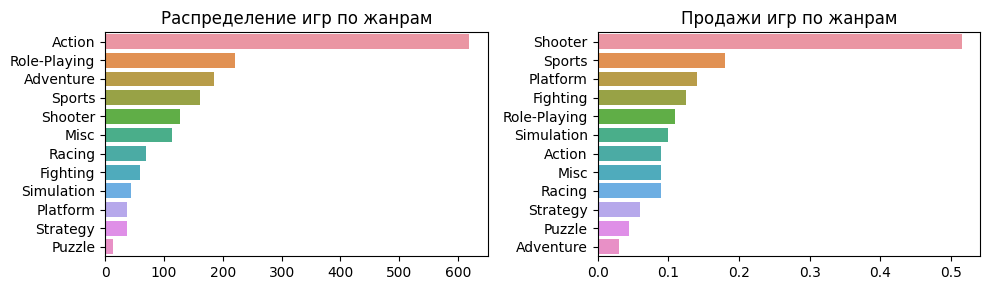

In [38]:
# визуализируем полученные данные:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

temp1 = actual_data_genre.sort_values(by='count', ascending=False)
temp2 = actual_data_genre.sort_values(by='avg_total_sales', ascending=False)

sns.barplot(data=temp1, x="count", y="genre", ax=axes[0]).set(
    title=('Распределение игр по жанрам'), xlabel='', ylabel='')

sns.barplot(data=temp2, x="avg_total_sales", y="genre", ax=axes[1]).set(
    title=('Продажи игр по жанрам'), xlabel='', ylabel='')

plt.tight_layout()

**Вывод:** Самыми прибыльными жанрами являются **Shooter и Sports.** Также в пятерку лидеров входят *Platform, Fighting и Role-Playing.*    
Что касается количества игр: здесь несомненно лидирует жанр **Action**. Далее равномерно распределены *Role-Playing, Adventure Sports, Shooter.*

Прежде всего прибыльность жанров может быть связана с количеством выпущенных в этом жанре игр. Также на прибыльность может влиять популярность жанра среди любителей компьютерных игр на определенный момент времени и страна проживания пользователя. 

## Определение портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):  
•	Самые популярные платформы (топ-5)  
•	Самые популярные жанры (топ-5)  
•	Влияет ли рейтинг ESRB на продажи в отдельном регионе

### Сформируем портрет пользователя для Северной Америки: 

#### Опреледим топ-5 платформ в регионе:

In [39]:
# создадим сводную таблицу по региону:
na_platform = actual_data.pivot_table(
    index='platform', 
    values='na_sales', 
    aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 платформам:
top5_platform_na = na_platform.head()
top5_platform_na

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05


#### Объединим платформы, не вошедшие в топ-5 в отдельную группу others:

In [40]:
# создадим словарь со значениями для новой строки в top5_platform:
new_row = {'platform': ['other'], 'na_sales': [na_platform[5:]['na_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_platform_na = top5_platform_na.append(other_data)
top5_platform_na

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05
0,other,31.19


#### Опреледим топ-5 жанров в регионе:

In [41]:
# создадим сводную таблицу по региону:
na_genre = actual_data.pivot_table(
    index='genre', 
    values='na_sales', 
    aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 жанрам:
top5_genre_na = na_genre.head()
top5_genre_na

,genre,na_sales
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05


#### Объединим жанры, не вошедшие в топ-5 в отдельную группу others:

In [42]:
# создадим словарь со значениями для новой строки в top5_genre_na:
new_row = {'genre': ['other'], 'na_sales': [na_genre[5:]['na_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_genre_na = top5_genre_na.append(other_data)
top5_genre_na

,genre,na_sales
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05
0,other,37.86


#### Проверим, влияет ли рейтинг ESRB на продажи в регионе:

In [43]:
# создадим сводную таблицу по региону:
rating_na = actual_data.pivot_table(
    index='rating', 
    values='na_sales', 
    aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)
rating_na

,rating,na_sales
2,M,96.42
4,unknown,64.72
0,E,50.74
3,T,38.95
1,E10+,33.23


#### Визуализируем все полученные данные для региона:

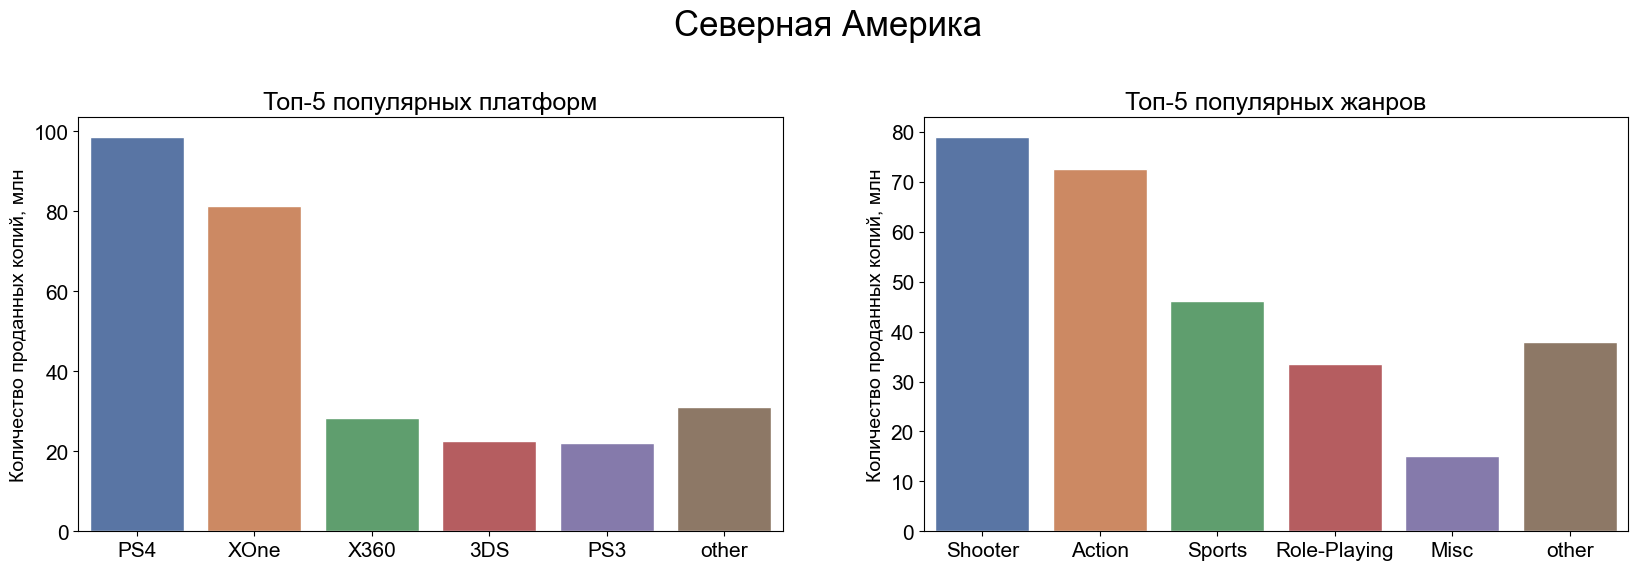

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

# зададим общее название региона
fig.suptitle('Северная Америка', fontsize=25)
fig.subplots_adjust(top=0.8)

#зададим параметры осей x,y:
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
sns.set_theme(style="whitegrid")

#создадим график распределения по платформам:
sns.barplot(
    data=top5_platform_na, 
    x='platform',
    y='na_sales', 
    ax=axes[0]).set(xlabel='')

# создадим график распределения по жанрам:
sns.barplot(
    data=top5_genre_na, 
    x='genre',
    y='na_sales', 
    ax=axes[1]).set(xlabel='')

# зададим названия графикам:
axes[0].set_title('Топ-5 популярных платформ', fontsize=18)
axes[1].set_title('Топ-5 популярных жанров', fontsize=18)

# зададим названия оси y:
axes[0].set_ylabel('Количество проданных копий, млн', fontsize=14) 
axes[1].set_ylabel('Количество проданных копий, млн', fontsize=14) 

plt.show()

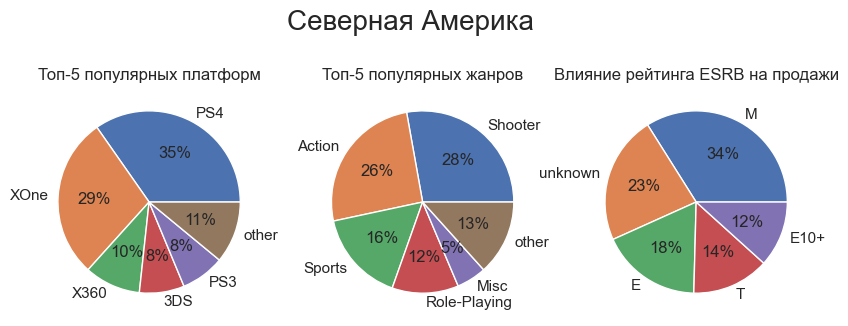

In [45]:
# Построим круговые диаграммы:
fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig.subplots_adjust(top=1.3)
fig.suptitle('Северная Америка', fontsize=20)
ax[0].pie(top5_platform_na['na_sales'], 
        labels=top5_platform_na['platform'], 
        autopct='%.0f%%')
ax[0].set_title('Топ-5 популярных платформ', fontsize=12)


# создадим график распределения по жанрам:
ax[1].pie(top5_genre_na['na_sales'], 
        labels=top5_genre_na['genre'], 
        autopct='%.0f%%')
ax[1].set_title('Топ-5 популярных жанров', fontsize=12)

# создадим график распределения по рейтингу:
ax[2].pie(rating_na['na_sales'], 
        labels=rating_na['rating'], 
        autopct='%.0f%%')
ax[2].set_title('Влияние рейтинга ESRB на продажи', fontsize=12)

plt.show()

**Вывод:** Портрет пользователя для Северной Америки:  
- Предпочитаемые консоли: PS4, XOne  
- Предпочитаемые жанры игр: Shooter, Action  
- Средний возраст (исходя из рейтинга ESRB): лица старше 17 лет

### Сформируем портрет пользователя для Европы: 

#### Опреледим топ-5 платформ в регионе:

In [46]:
# создадим сводную таблицу по региону:
eu_platform = actual_data.pivot_table(
    index='platform', 
    values='eu_sales', 
    aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 платформам:
top5_platform_eu = eu_platform.head()
top5_platform_eu

,platform,eu_sales
3,PS4,130.04
9,XOne,46.25
2,PS3,25.54
1,PC,17.97
0,3DS,16.12


#### Объединим платформы, не вошедшие в топ-5 в отдельную группу others:

In [47]:
# создадим словарь со значениями для новой строки в top5_genre_eu:
new_row = {'platform': ['other'], 'eu_sales': [eu_platform[5:]['eu_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_platform_eu = top5_platform_eu.append(other_data)
top5_platform_eu

,platform,eu_sales
3,PS4,130.04
9,XOne,46.25
2,PS3,25.54
1,PC,17.97
0,3DS,16.12
0,other,34.76


#### Опреледим топ-5 жанров в регионе:

In [48]:
# создадим сводную таблицу по региону:
eu_genre = actual_data.pivot_table(
    index='genre', 
    values='eu_sales', 
    aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 жанрам:
top5_genre_eu = eu_genre.head()
top5_genre_eu

,genre,eu_sales
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13


#### Объединим жанры, не вошедшие в топ-5 в отдельную группу others:

In [49]:
# создадим словарь со значениями для новой строки в top5_genre_eu:
new_row = {'genre': ['other'], 'eu_sales': [eu_genre[5:]['eu_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_genre_eu = top5_genre_eu.append(other_data)
top5_genre_eu

,genre,eu_sales
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13
0,other,42.45


#### Проверим, влияет ли рейтинг ESRB на продажи в регионе:

In [50]:
# создадим сводную таблицу по региону:
rating_eu = actual_data.pivot_table(
    index='rating', 
    values='eu_sales', 
    aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)
rating_eu

,rating,eu_sales
2,M,93.44
4,unknown,58.95
0,E,58.06
3,T,34.07
1,E10+,26.16


#### Визуализируем все полученные данные для региона:

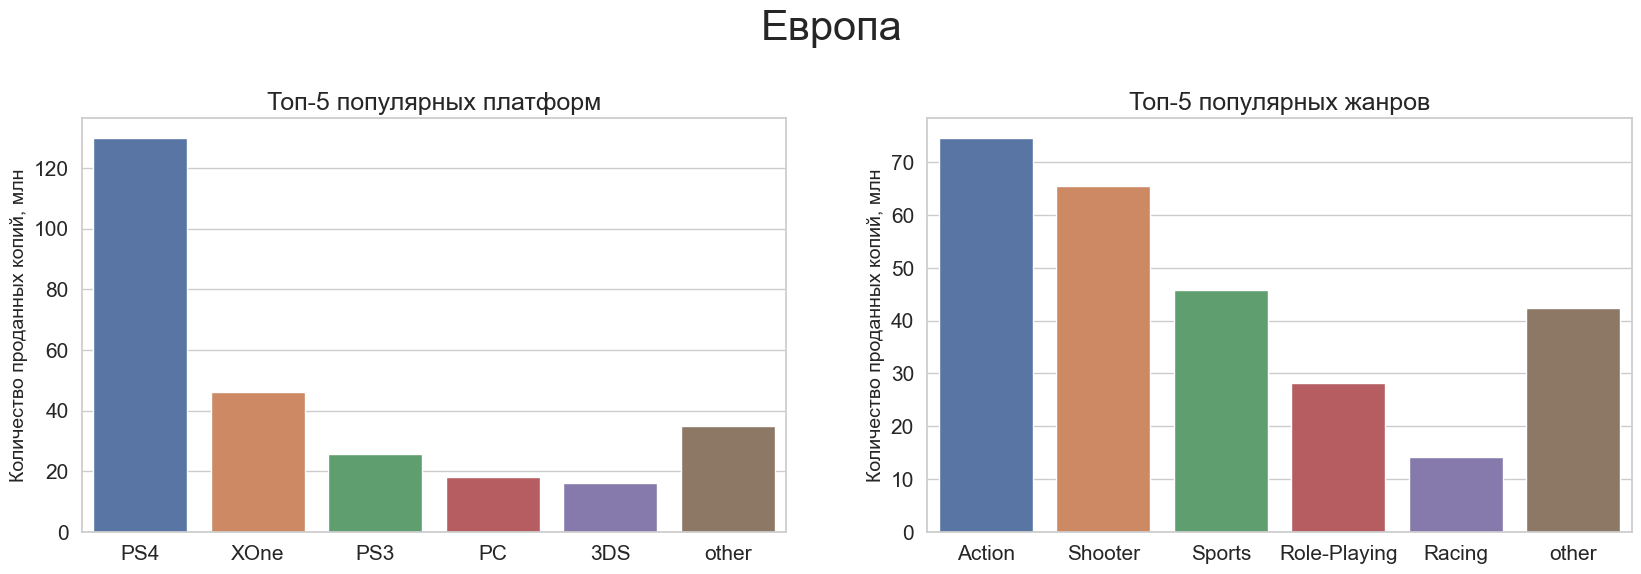

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

# зададим общее название региона
fig.suptitle('Европа', fontsize=30)
fig.subplots_adjust(top=0.8)

#зададим параметры осей x,y:
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)

#создадим график распределения по платформам:
sns.barplot(
    data=top5_platform_eu, 
    x='platform',
    y='eu_sales', 
    ax=axes[0]).set(xlabel='')

# создадим график распределения по жанрам:
sns.barplot(
    data=top5_genre_eu, 
    x='genre',
    y='eu_sales', 
    ax=axes[1]).set(xlabel='')

# зададим названия графикам:
axes[0].set_title('Топ-5 популярных платформ', fontsize=18)
axes[1].set_title('Топ-5 популярных жанров', fontsize=18)

# зададим названия оси y:
axes[0].set_ylabel('Количество проданных копий, млн', fontsize=14) 
axes[1].set_ylabel('Количество проданных копий, млн', fontsize=14) 

plt.show()

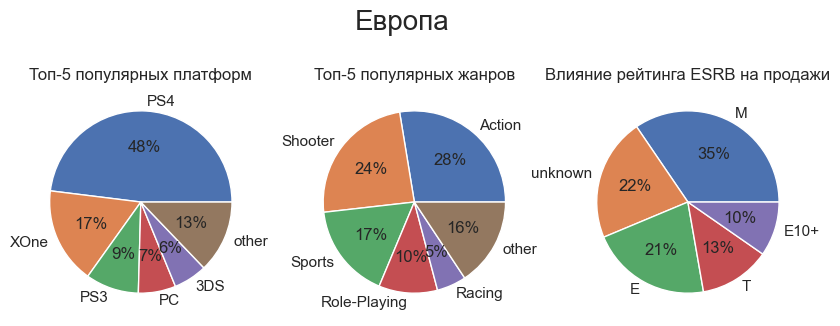

In [52]:
# Построим круговые диаграммы:
fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig.subplots_adjust(top=1.3)
fig.suptitle('Европа', fontsize=20)
ax[0].pie(top5_platform_eu['eu_sales'], 
        labels=top5_platform_eu['platform'], 
        autopct='%.0f%%')
ax[0].set_title('Топ-5 популярных платформ', fontsize=12)


# создадим график распределения по жанрам:
ax[1].pie(top5_genre_eu['eu_sales'], 
        labels=top5_genre_eu['genre'], 
        autopct='%.0f%%')
ax[1].set_title('Топ-5 популярных жанров', fontsize=12)

# создадим график распределения по рейтингу:
ax[2].pie(rating_eu['eu_sales'], 
        labels=rating_eu['rating'], 
        autopct='%.0f%%')
ax[2].set_title('Влияние рейтинга ESRB на продажи', fontsize=12)

plt.show()

**Вывод:** Портрет пользователя для Европы:

- Предпочитаемые консоли: PS4, XOne  
- Предпочитаемые жанры игр: Action, Shooter  
- Средний возраст (исходя из рейтинга ESRB): лица старше 17 лет  

### Сформируем портрет пользователя для Японии: 

#### Опреледим топ-5 платформ в регионе:

In [53]:
# создадим сводную таблицу по региону:
jp_platform = actual_data.pivot_table(
    index='platform', 
    values='jp_sales', 
    aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 платформам:
top5_platform_jp = jp_platform.head()
top5_platform_jp

,platform,jp_sales
0,3DS,44.24
3,PS4,15.02
5,PSV,14.54
2,PS3,11.22
7,WiiU,7.31


#### Объединим платформы, не вошедшие в топ-5 в отдельную группу others:

In [54]:
# создадим словарь со значениями для новой строки в top5_genre_eu:
new_row = {'platform': ['other'], 'jp_sales': [jp_platform[5:]['jp_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_platform_jp = top5_platform_jp.append(other_data)
top5_platform_jp

,platform,jp_sales
0,3DS,44.24
3,PS4,15.02
5,PSV,14.54
2,PS3,11.22
7,WiiU,7.31
0,other,0.76


#### Опреледим топ-5 жанров в регионе:

In [55]:
# создадим сводную таблицу по региону:
jp_genre = actual_data.pivot_table(
    index='genre', 
    values='jp_sales', 
    aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

# создадим переменную, где будут только данные по топ-5 жанрам:
top5_genre_jp = jp_genre.head()
top5_genre_jp

,genre,jp_sales
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87


#### Объединим жанры, не вошедшие в топ-5 в отдельную группу others:

In [56]:
# создадим словарь со значениями для новой строки в top5_genre_eu:
new_row = {'genre': ['other'], 'jp_sales': [jp_genre[5:]['jp_sales'].sum()]}

# cформируем dataframe из словаря:
other_data= pd.DataFrame.from_dict(new_row)

# присоединим полученный df к нашему списку топ-5:
top5_genre_jp = top5_genre_jp.append(other_data)
top5_genre_jp

,genre,jp_sales
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87
0,other,15.50


#### Проверим, влияет ли рейтинг ESRB на продажи в регионе:

In [57]:
# создадим сводную таблицу по региону:
rating_jp = actual_data.pivot_table(
    index='rating', 
    values='jp_sales', 
    aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)
rating_jp

,rating,jp_sales
4,unknown,56.90
3,T,14.78
0,E,8.94
2,M,8.01
1,E10+,4.46


#### Визуализируем все полученные данные для региона:

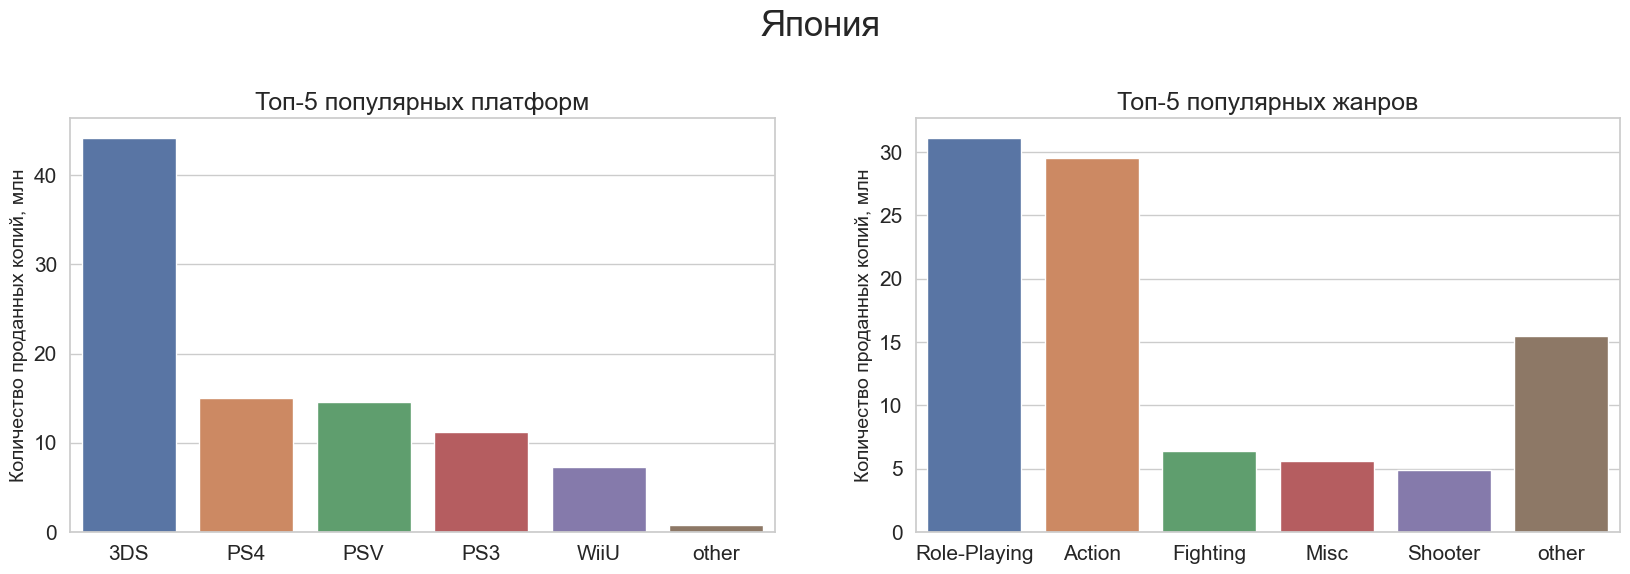

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

# зададим общее название региона
fig.suptitle('Япония', fontsize=25)
fig.subplots_adjust(top=0.8)

#зададим параметры осей x,y:
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)

#создадим график распределения по платформам:
sns.barplot(
    data=top5_platform_jp, 
    x='platform',
    y='jp_sales', 
    ax=axes[0]).set(xlabel='')

# создадим график распределения по жанрам:
sns.barplot(
    data=top5_genre_jp, 
    x='genre',
    y='jp_sales', 
    ax=axes[1]).set(xlabel='')

# зададим названия графикам:
axes[0].set_title('Топ-5 популярных платформ', fontsize=18)
axes[1].set_title('Топ-5 популярных жанров', fontsize=18)

# зададим названия оси y:
axes[0].set_ylabel('Количество проданных копий, млн', fontsize=14) 
axes[1].set_ylabel('Количество проданных копий, млн', fontsize=14) 

plt.show()

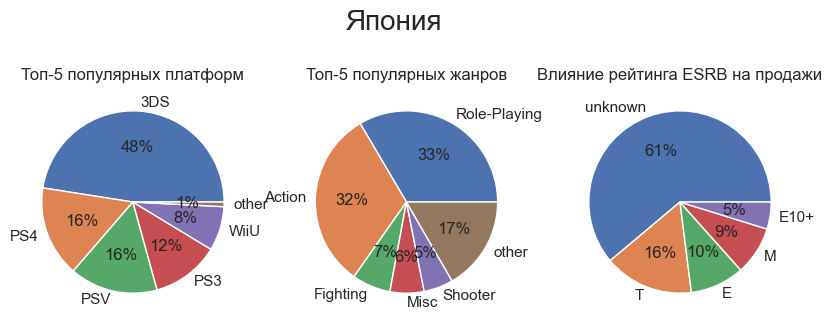

In [59]:
# Построим круговые диаграммы:
fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig.subplots_adjust(top=1.3)
fig.suptitle('Япония', fontsize=20)
ax[0].pie(top5_platform_jp['jp_sales'], 
        labels=top5_platform_jp['platform'], 
        autopct='%.0f%%')
ax[0].set_title('Топ-5 популярных платформ', fontsize=12)


# создадим график распределения по жанрам:
ax[1].pie(top5_genre_jp['jp_sales'], 
        labels=top5_genre_jp['genre'], 
        autopct='%.0f%%')
ax[1].set_title('Топ-5 популярных жанров', fontsize=12)

# создадим график распределения по рейтингу:
ax[2].pie(rating_jp['jp_sales'], 
        labels=rating_jp['rating'], 
        autopct='%.0f%%')
ax[2].set_title('Влияние рейтинга ESRB на продажи', fontsize=12)

plt.show()

**Вывод:** Портрет пользователя для Японии:  
- Предпочитаемые консоли: 3DS, PSV
- Предпочитаемые жанры игр: Role-Playing, Action
- Средний возраст (исходя из рейтинга ESRB): неизвестен

In [60]:
# объединим данные по рейтингам в каждом регионе из сводных таблиц в одну:
rating_pivot = pd.concat([rating_jp, rating_na,rating_eu]).groupby(
    by='rating').sum().sort_values(by='rating', ascending=False).reset_index()
rating_pivot

,rating,jp_sales,na_sales,eu_sales
0,unknown,56.90,64.72,58.95
1,T,14.78,38.95,34.07
2,M,8.01,96.42,93.44
3,E10+,4.46,33.23,26.16
4,E,8.94,50.74,58.06


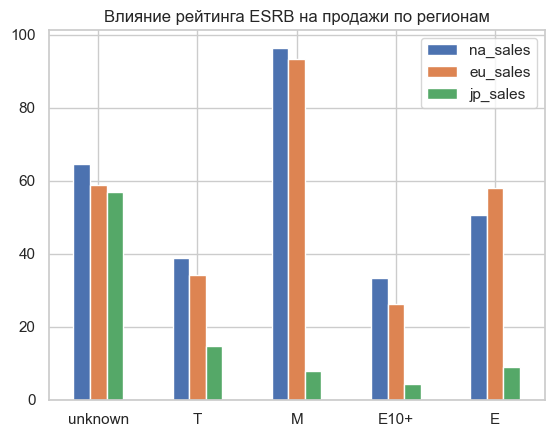

In [61]:
# отобразим на графике влияние рейтинга на продажи для каждого из регионов:
ax = rating_pivot.plot(
    x='rating', 
    y=['na_sales', 'eu_sales', 'jp_sales'], 
    kind="bar", 
    rot=0).set(
    title='Влияние рейтинга ESRB на продажи по регионам',
    xlabel='')

**Вывод:** По итогам исследования было сформировано 3 портрета пользователей для каждого из регионов (NA, EU, JP).  
Пользователи **Северной Америки** и **Европы** *схожи* в своих предпочтениях: самыми популярными консолями в обоих регионах являются **PS4 и XOne**, а наиболее предпочитаемыми игровыми жанрами являются **Action и Shooter.** Средний возраст игроков (исходя из рейтинга ESRB) также индентичен: это игроки старше 17 лет.  

Пользователи **Японии** разительно *отличаются* от двух предыдущих регионов. Они выбирают японские консоли **3DS и PSV**, а игровые жанры **Role-Playing и Action.** Средний возвраст для большей части игроков неизвестен, так как агентство ESRB оценивает только игры, продающиеся на территории США, Мексики и Канады.   

В Северной Америке и Европе рейтинг ESRB ***влияет*** на продажи. Это видно исходя из количества проданных игр в категории **М** (лица старше 17 лет), что соответствует основной аудитории, предпочитающей жанры Action и Shooter. В Японии данный рейтинг **никак не влияет** на продажи, так как большинство продающихся игр не участвуют в данном рейтинге. 

## Проверка гипотез

### Проведем проверку для ряда гипотез:

1. **Нулевая гипотеза:** средние пользовательские рейтинги платформ Xbox One и PC ***равны***  
   **Альтернативная гипотеза:** средние пользовательские рейтинги платформ Xbox One и PC ***не равны***

In [62]:
# сохраним значения рейтинга пользователей по платформе РС:
mean_user_score_pc = actual_data[(actual_data['user_score'] != -1) & 
                                 (actual_data['platform'] == 'PC') &
                                 (~actual_data['user_score'].isna())]['user_score']

# сохраним значения рейтинга пользователей по платформе Xbox One:
mean_user_user_score_xone = actual_data[(actual_data['user_score'] != -1) & 
                                        (actual_data['platform'] == 'XOne') &
                                        (~actual_data['user_score'].isna())]['user_score']

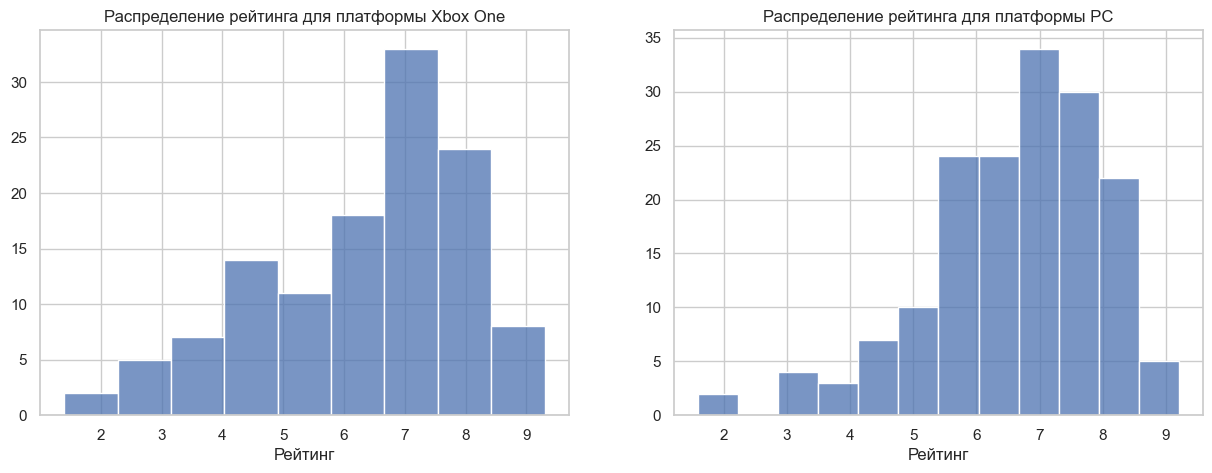

In [63]:
# визуализируем распределение для каждой из выборок:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(data=mean_user_score_pc,
             ax=axes[0]).set(title='Распределение рейтинга для платформы Xbox One',
                             xlabel='Рейтинг',
                             ylabel='')

sns.histplot(data=mean_user_user_score_xone,
             ax=axes[1]).set(title='Распределение рейтинга для платформы PC',
                             xlabel='Рейтинг',
                             ylabel='')
plt.show()

Исходя из графиков, обе выборки рейтингов имеют нормальное распределение.    

Для проверки гипотезы будем использовать метод **ttest_ind().**

In [64]:
# посчитаем значения дисперсии для каждой выборки:
print('Дисперсия средних пользовательских рейтингов платформ Xbox One:', round(np.var(mean_user_score_pc, ddof=1),2))
print('Дисперсия средних пользовательских рейтингов платформ PC:', round(np.var(mean_user_user_score_xone, ddof=1),2))

Дисперсия средних пользовательских рейтингов платформ Xbox One: 2.9
Дисперсия средних пользовательских рейтингов платформ PC: 1.89


Дисперсия выборок не равна, поэтому учтем это при тестировании гипотезы в параметре *equal_var.*  
Проведем **t-тест** для проверки гипотезы:

In [65]:
# напишем функцию для проведения t-теста:
def t_test(data_1, data_2):
    alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

    results = st.ttest_ind(data_1, data_2, equal_var = False)
    print('p-значение:', results.pvalue)
    
    if results.pvalue < alpha:
        return print('Отвергаем нулевую гипотезу')

    else:
        return print('Не получилось отвергнуть нулевую гипотезу')

In [66]:
# применим функцию для проверки первой гипотезы:
t_test(mean_user_score_pc, mean_user_user_score_xone)

p-значение: 0.11601398086668835
Не получилось отвергнуть нулевую гипотезу


Исходя из проведенного теста, нулевая гипотеза не отвергнута. Это говорит о том, что на основании имеющихся данных опровергнуть равенство средних пользовательских рейтингов платформ Xbox One и PC не удалось. 

2. **Нулевая гипотеза:** средние пользовательские рейтинги жанров Action и Sports ***равны***  
**Альтернативная гипотеза:** средние пользовательские рейтинги жанров Action и Sports ***не равны***

In [67]:
# сохраним значения рейтинга пользователей для жанра Action:
mean_user_score_action = actual_data[(actual_data['user_score'] != -1) & 
                                     (actual_data['genre'] == 'Action') &
                                     (~actual_data['user_score'].isna())]['user_score']

# сохраним значения среднего рейтинга пользователей для жанра Sports:
mean_user_user_score_sports = actual_data[(actual_data['user_score'] != -1) & 
                                          (actual_data['genre'] == 'Sports') &
                                          (~actual_data['user_score'].isna())]['user_score']

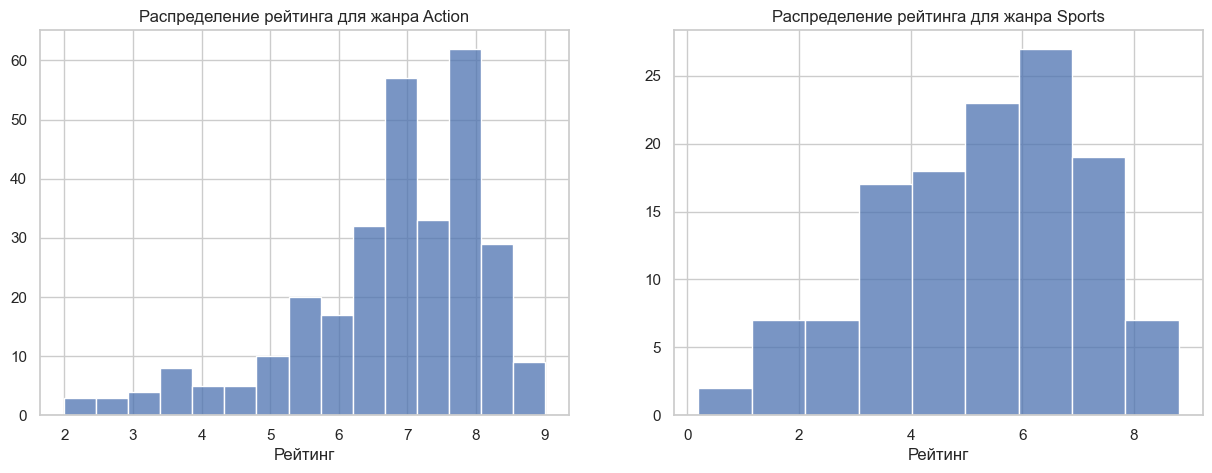

In [68]:
# визуализируем распределение для каждой из выборок:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(data=mean_user_score_action,
             ax=axes[0]).set(title='Распределение рейтинга для жанра Action',
                             xlabel='Рейтинг',
                             ylabel='')

sns.histplot(data=mean_user_user_score_sports,
             ax=axes[1]).set(title='Распределение рейтинга для жанра Sports',
                             xlabel='Рейтинг',
                             ylabel='')
plt.show()

Исходя из графиков, обе выборки рейтингов имеют нормальное распределение.

Для проверки второй гипотезы будем также использовать метод **ttest_ind().**

In [69]:
# посчитаем значения дисперсии для каждой выборки:
print('Дисперсия средних пользовательских рейтингов жанров Action:', round(np.var(mean_user_score_action, ddof=1),2))
print('Дисперсия средних пользовательских рейтингов жанров Sports:', round(np.var(mean_user_user_score_sports, ddof=1),2))

Дисперсия средних пользовательских рейтингов жанров Action: 1.9
Дисперсия средних пользовательских рейтингов жанров Sports: 3.45


Дисперсия выборок не равна, поэтому учтем это при тестировании гипотезы в параметре *equal_var.*

In [70]:
# применим функцию для проверки второй гипотезы:
t_test(mean_user_score_action, mean_user_user_score_sports)

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Исходя из проведенного теста, нулевая гипотеза отвергнута. Это говорит о том, что на основании имеющихся данных нам удалось опровергнуть равенство средних пользовательских рейтингов жанров Action и Sports.

**Вывод:** Нулевая гипотеза – это основное проверяемое предположение, которое обычно формулируется как отсутствие различий.  
При формировании ***нулевой*** гипотезы я исходила из того, что выборочные средние двух генеральных совокупностей ***равны.***  
При формировании ***альтернативной*** гипотезы я исходила из того, что выборочные средние двух генеральных совокупностей ***не равны*** друг другу.   

Для проверки гипотез был выбран t-test по следующим причинам:
- Гипотезы проверялись не на всех данных, а по взятым из них выборкам
- Данные в двух рассматриваемых выборках не зависят друг от друга  
- Выборочные средние данных нормально распределены  

Исходя из ЦПТ (центральная предельная теорема), если размер выборки составляет хотя бы несколько десятков значений, выборочные средние будут распределены нормально вокруг истинного среднего этой совокупности. Это утверждение верно, даже если сама генеральная совокупность не распределена нормально.  


## Общий вывод

Исследование состояло из четырех основных этапов:  

**1. Знакомство с данными:**
- Получена общая информацию о датафрейме
- Сформировано первое представление о полученных данных

**2. Предобработка данных:**  
- Исправлены ошибки в стиле заголовков
- Заполнены пропущенные значения в столбцах, где это возможно
- Указаны причины, которые могли привести к пропускам в данных
- Преобразованы типы данных в столбцах, где это необходимо
- Посчитаны суммарные продажи во всех регионах и добавлены в основной датасет

**3. Исследовательский анализ данных:**
- Изучено, сколько игр выпускалось в разные годы
- Изучено, как менялись продажи по платформам
- Выбраны платформы с наибольшими суммарными продажами
- Построено распределение суммарных продаж по годам среди платформ-лидеров
- Определен актуальный период для исследования
- Изучена динамика продаж среди игровых консолей
- Выбрано несколько потенциально прибыльных платформ
- Построена диаграмма размаха по глобальным продажам игр в разбивке по платформам
- Проверено наличие связей между продажами и отзывами пользователей, продажами и отзывами критиков для всех консолей
- Изучено общее распределение игр по жанрам
- Выделены самые прибыльные игровые жанры
- Сформированы портреты пользователей для каждого региона (NA, EU, JP)  

**4. Проверка гипотез:**
- Проверена гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC
- Проверена гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports

Исследуя данные о продажах игр, оценки пользователей и экспертов, различные жанры и игровые платформы были выявлены следующие закономерности:
- Самой популярной игровой платформой является PS4
- В пятерку лидеров популярных платформ также входят консоли XOne, X360, Wii, WiiU
- Самыми прибыльными игровыми жанрами являются Action, Shooter, Sports и Role-Playing
- Самыми крупными по количеству выпускаемых игр являются жанры Action, Role-Playing, Adventure, Sports и Shooter
- Пользователи Северной Америки и Европы предпочитают игровые консоли PS4 и XOne и игры в жанрах Action и Shooter 
- Средний возраст игроков (исходя из рейтинга ESRB) для Северной Америки и Европы: старше 17 лет (взрослая аудитория)
- Пользователи Японии выбирают японские консоли 3DS и PSV, а игровые жанры Role-Playing и Action
- В Северной Америке и Европе рейтинг ESRB влияет на продажи игр
- В Японии рейтинг ESRB никак не влияет на продажи, так как большинство продающихся игр не участвуют в данном рейтинге
- Оценки пользователей не оказывают влияние на продажи для большей части игровых консолей
- Для платформ PS4, 3DS, XOne, WiiU, PS3, X360 прослеживается влияние оценок критиков на суммарные продажи
- У японских консолей WiiU и Wii оценки пользователей влияют на их суммарные продажи
- Японские консоли Wii и PSP в принципе не имеют оценок критиков
- Платформа PSP не имеет ни оценок критиков, ни оценок пользователей, поэтому невозможно оценить влияние параметров на суммарные продажи платформы